### Importazione librerie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools
import random
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import plotly.graph_objects as go

### Lettura dati

In [2]:
order_book_df = pd.read_csv('Bitcoin (USDT) arricchito 2024 timeframe 5m.csv')
order_book_df.set_index('timestamp', inplace=True)
order_book_df.index = pd.to_datetime(order_book_df.index)
order_book_df = order_book_df.iloc[:, :15]
order_book_df

,open,high,low,close,volume,notional_-5,notional_-4,notional_-3,notional_-2,notional_-1,notional_1,notional_2,notional_3,notional_4,notional_5
timestamp,,,,,,,,,,,,,,,
2024-04-19 00:00:00,63470.09,63470.09,63272.60,63283.05,171.66048,2.805868e+08,2.546757e+08,2.235747e+08,1.712686e+08,8.151701e+07,8.958049e+07,2.323875e+08,2.885844e+08,3.980131e+08,4.338895e+08
2024-04-19 00:05:00,63283.05,63283.05,63072.99,63089.99,129.03663,2.979414e+08,2.626244e+08,2.317270e+08,1.866406e+08,8.880829e+07,7.741155e+07,2.146845e+08,2.813204e+08,3.904839e+08,4.277976e+08
2024-04-19 00:10:00,63090.00,63090.00,62912.64,62913.99,209.10677,3.093996e+08,2.624514e+08,2.300250e+08,1.892556e+08,8.843862e+07,7.034354e+07,1.965954e+08,2.765930e+08,3.623605e+08,4.223972e+08
2024-04-19 00:15:00,62914.00,63073.00,62913.99,63068.00,123.27576,3.168050e+08,2.667421e+08,2.336174e+08,1.932235e+08,9.231861e+07,7.493420e+07,1.840083e+08,2.711391e+08,3.150917e+08,4.182899e+08
2024-04-19 00:20:00,63068.00,63106.57,62990.95,62992.11,56.42708,3.300506e+08,2.808887e+08,2.477095e+08,2.006171e+08,1.016706e+08,7.919234e+07,2.027902e+08,2.755209e+08,3.523499e+08,4.187225e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:35:00,93546.03,93546.03,93456.02,93464.26,37.27614,8.928054e+08,7.590884e+08,4.991608e+08,3.300921e+08,1.791560e+08,9.927997e+07,1.716579e+08,2.532281e+08,3.071396e+08,3.720481e+08
2024-12-31 23:40:00,93464.27,93504.00,93456.00,93490.87,23.44102,8.939847e+08,7.628307e+08,5.104306e+08,3.353413e+08,1.824000e+08,9.365534e+07,1.730503e+08,2.493083e+08,3.060481e+08,3.639250e+08
2024-12-31 23:45:00,93490.86,93544.50,93484.30,93544.49,23.00051,8.940680e+08,7.583909e+08,5.041382e+08,3.324905e+08,1.801727e+08,8.778805e+07,1.693768e+08,2.473854e+08,3.007457e+08,3.583649e+08


### Function

In [3]:
# Funzione per calcolare le feature con derivata dell'imbalance
def compute_features(df, bid_level=-3, ask_level=3, ma_window=12):
    """
    Calcola le feature a partire dai dati dell'order book, inclusa la derivata dell'imbalance.
    """
    df = df.copy()
    bid_column = f'notional_{bid_level}'
    ask_column = f'notional_{ask_level}'
    df['bid_cum'] = df[bid_column]
    df['ask_cum'] = df[ask_column]
    df['imbalance'] = (df['bid_cum'] - df['ask_cum']) / (df['bid_cum'] + df['ask_cum'] + 1e-6)
    df['imbalance_diff'] = df['imbalance'].diff()  # Derivata dell'imbalance
    df[f'ma_{ma_window}'] = df['close'].rolling(window=ma_window, min_periods=1).mean()
    return df

# Funzione per generare segnali con filtro su imbalance e sua derivata
def generate_signals(df, freq='5min', long_thresh=0.05, short_thresh=-0.05, ma_window=12, bid_level=-3, ask_level=3):
    """
    Genera segnali basati su imbalance, sua derivata e media mobile:
    - Long se imbalance > long_thresh, imbalance_diff > 0 e close > MA
    - Short se imbalance < short_thresh, imbalance_diff < 0 e close < MA
    """
    ma_column = f'ma_{ma_window}'
    bid_col = f'notional_{bid_level}'
    ask_col = f'notional_{ask_level}'
    df_resampled = df.resample(freq).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'imbalance': 'mean',
        'imbalance_diff': 'mean',
        ma_column: 'last',
        bid_col: 'last',
        ask_col: 'last'
    })
    df_resampled = df_resampled.ffill()
    
    long_condition = (df_resampled['imbalance'] > long_thresh) & (df_resampled['imbalance_diff'] > 0) & (df_resampled['close'] > df_resampled[ma_column])
    short_condition = (df_resampled['imbalance'] < short_thresh) & (df_resampled['imbalance_diff'] < 0) & (df_resampled['close'] < df_resampled[ma_column])
    
    df_resampled['signal'] = 0
    df_resampled.loc[long_condition, 'signal'] = 1
    df_resampled.loc[short_condition, 'signal'] = -1
    return df_resampled

# Funzione di backtest
def backtest_strategy(df, bid_level=-3, ask_level=3, decision_freq='h', 
                      long_thresh=0.05, short_thresh=-0.05, initial_capital=100, ma_window=12):
    df = df.sort_index()
    df = compute_features(df, bid_level=bid_level, ask_level=ask_level, ma_window=ma_window)
    signals_df = generate_signals(df, freq=decision_freq, long_thresh=long_thresh, 
                                  short_thresh=short_thresh, ma_window=ma_window, bid_level=bid_level, ask_level=ask_level)
    
    cash = initial_capital
    position = 0
    entry_price = None
    trades = []
    portfolio_history = []
    
    previous_signal = 0
    bid_col = f'notional_{bid_level}'
    ask_col = f'notional_{ask_level}'
    
    for timestamp, row in signals_df.iterrows():
        current_price = row['close']
        signal = row['signal']
        portfolio_value = cash + position * current_price
        portfolio_history.append({'timestamp': timestamp, 'portfolio': portfolio_value})
        
        # Se il segnale cambia rispetto al precedente
        if signal != previous_signal:
            # Chiusura posizione esistente
            if position != 0:
                exit_price = current_price
                if position > 0:
                    pnl = position * (exit_price - entry_price)
                    cash += position * exit_price
                else:
                    pnl = -position * (entry_price - exit_price)
                    cash += position * exit_price
                position = 0
                trades.append({
                    'timestamp': timestamp,
                    'action': 'exit',
                    'position': 0,
                    'price': exit_price,
                    'portfolio': portfolio_value,
                    'pnl': pnl,
                    'cash': cash,
                    'signal': signal,
                    'imbalance': row['imbalance'],
                    'imbalance_diff': row['imbalance_diff'],
                    'close': row['close'],
                    bid_col: row[bid_col],
                    ask_col: row[ask_col]
                })
                entry_price = None
            
            # Apertura nuova posizione
            if signal != 0 and portfolio_value > 0:
                if signal == 1:
                    quantity = cash / current_price
                    position = quantity
                    cash = 0
                    entry_price = current_price
                elif signal == -1:
                    quantity = cash / current_price
                    position = -quantity
                    cash += quantity * current_price
                    entry_price = current_price
                trades.append({
                    'timestamp': timestamp,
                    'action': 'enter',
                    'position': position,
                    'price': current_price,
                    'portfolio': portfolio_value,
                    'entry_price': entry_price,
                    'pnl': None,
                    'cash': cash,
                    'signal': signal,
                    'imbalance': row['imbalance'],
                    'imbalance_diff': row['imbalance_diff'],
                    'close': row['close'],
                    bid_col: row[bid_col],
                    ask_col: row[ask_col]
                })
        else:
            trades.append({
                'timestamp': timestamp,
                'action': 'hold',
                'position': position,
                'price': current_price,
                'portfolio': portfolio_value,
                'pnl': None,
                'cash': cash,
                'signal': signal,
                'imbalance': row['imbalance'],
                'imbalance_diff': row['imbalance_diff'],
                'close': row['close'],
                bid_col: row[bid_col],
                ask_col: row[ask_col]
            })
        
        previous_signal = signal
    
    final_portfolio = cash + (position * signals_df.iloc[-1]['open']) if position != 0 else cash
    trades_df = pd.DataFrame(trades)
    portfolio_df = pd.DataFrame(portfolio_history).set_index('timestamp')
    
    return trades_df, final_portfolio, portfolio_df

# Funzione per calcolare la performance (invariata)
def evaluate_performance(trades_df):
    portfolio_series = trades_df['portfolio']
    running_max = portfolio_series.cummax()
    drawdown = (portfolio_series - running_max) / running_max
    max_drawdown = drawdown.min()
    return max_drawdown

# Wrapper per il backtest come funzione obiettivo
def objective_function(params, df_train, df_val, initial_capital):
    # Converti parametri in interi dove necessario
    params_converted = {
        k: int(v) if k in ['bid_level', 'ask_level', 'ma_window'] else v
        for k, v in params.items()
    }
    
    # Backtest sul train
    trades_train, final_portfolio_train, portfolio_df_train = backtest_strategy(
        df_train, **params_converted, initial_capital=initial_capital
    )
    max_dd_train = evaluate_performance(trades_train)
    performance_train = final_portfolio_train + 100 * max_dd_train
    
    # Backtest sul validation
    trades_val, final_portfolio_val, portfolio_df_val = backtest_strategy(
        df_val, **params_converted, initial_capital=initial_capital
    )
    max_dd_val = evaluate_performance(trades_val)
    performance_val = final_portfolio_val + 100 * max_dd_val
    
    # Stampa di log dettagliata
    print(f"Parametri testati: {params_converted}")
    print(f"Train - Portafoglio finale: {final_portfolio_train:.2f}, Max Drawdown: {max_dd_train:.4f}, "
          f"Performance: {performance_train:.2f}")
    print(f"Validation - Portafoglio finale: {final_portfolio_val:.2f}, Max Drawdown: {max_dd_val:.4f}, "
          f"Performance: {performance_val:.2f}")
    
    # Restituisci performance_train per guidare l'ottimizzazione
    return performance_train, performance_val, params_converted

def bayesian_optimization(df, param_space, initial_capital=100, train_ratio=0.6, val_ratio=0.2, max_iter=50, patience=5):
    """
    Ottimizza i parametri con un approccio bayesiano, usando il train set per guidare l'esplorazione
    e il validation set per l'early stopping.
    """
    df = df.sort_index()
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    df_train = df.iloc[:train_end]
    df_val = df.iloc[train_end:val_end]
    df_test = df.iloc[val_end:]
    
    best_params = None
    best_performance_val = -np.inf
    patience_counter = 0
    results = []
    
    # Utilizza direttamente param_space come spazio dei parametri
    space = param_space
    dimensions = space  # Non è più necessario estrarre le dimensioni
    
    # Crea la funzione obiettivo per gp_minimize
    @use_named_args(space)  # Passa space con i nomi a @use_named_args
    def objective(**params):
        performance_train, performance_val, params_converted = objective_function(params, df_train, df_val, initial_capital)
        return -performance_train  # gp_minimize minimizza, quindi usiamo -performance_train
    
    # Callback per early stopping
    def callback(res):
        nonlocal patience_counter, best_performance_val, best_params, results
        # Estrai i nomi direttamente dalle dimensioni
        param_names = [dim.name for dim in space]  # <-- Modifica questa linea
        params = dict(zip(param_names, res.x))     # <-- Usa param_names invece della list comprehension precedente
        
        performance_train, performance_val, params_converted = objective_function(params, df_train, df_val, initial_capital)
        
        # Aggiungi ai risultati
        results.append({
            **params_converted,
            'performance_train': performance_train,
            'performance_val': performance_val
        })
        
        # Controlla se è il miglior validation
        if performance_val > best_performance_val:
            best_performance_val = performance_val
            best_params = params_converted
            patience_counter = 0
            print(f"--> Nuovo best trovato all'iterazione {len(res.func_vals)}: {best_params}")
        else:
            patience_counter += 1
            print(f"Iterazione {len(res.func_vals)}: {params_converted}, Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"--> Patience raggiunto. Interruzione all'iterazione {len(res.func_vals)}.")
            return True  # Ferma l'ottimizzazione
        return False
    
    # Esegui l'ottimizzazione con gp_minimize
    res = gp_minimize(
        func=objective,
        dimensions=dimensions,  # Passa solo le dimensioni a gp_minimize
        n_calls=max_iter,
        random_state=42,
        verbose=True,
        callback=callback
    )
    
    # Valutazione finale con i migliori parametri
    trades_train, final_portfolio_train, portfolio_df_train = backtest_strategy(df_train, **best_params, initial_capital=initial_capital)
    max_dd_train = evaluate_performance(trades_train)
    trades_val, final_portfolio_val, portfolio_df_val = backtest_strategy(df_val, **best_params, initial_capital=initial_capital)
    max_dd_val = evaluate_performance(trades_val)
    trades_test, final_portfolio_test, portfolio_df_test = backtest_strategy(df_test, **best_params, initial_capital=initial_capital)
    max_dd_test = evaluate_performance(trades_test)
    
    print(f"\nRisultati finali con i migliori parametri {best_params}:")
    print(f"  Train - Portafoglio: {final_portfolio_train:.2f}, Max DD: {max_dd_train:.4f}")
    print(f"  Val - Portafoglio: {final_portfolio_val:.2f}, Max DD: {max_dd_val:.4f}")
    print(f"  Test - Portafoglio: {final_portfolio_test:.2f}, Max DD: {max_dd_test:.4f}")
    
    return (best_params, final_portfolio_train, portfolio_df_train, max_dd_train, 
            final_portfolio_val, portfolio_df_val, max_dd_val, 
            final_portfolio_test, portfolio_df_test, max_dd_test, 
            pd.DataFrame(results), df_train, df_val, df_test)

def align_signals(signals, btc_prices):
    """Allinea i prezzi dei segnali al prezzo resampled più vicino"""
    aligned_prices = []
    for ts in signals['timestamp']:
        nearest_idx = btc_prices.index.get_indexer([ts], method='nearest')[0]
        aligned_prices.append(btc_prices.iloc[nearest_idx]['close'])
    return aligned_prices

def create_hover_text(df):
    """
    Crea una lista di stringhe formattate per il tooltip,
    ciascuna contenente le info di una riga del dataframe.
    """
    hover_texts = []
    for _, row in df.iterrows():
        # Genera una stringa con "colonna: valore" per ogni colonna
        text = "<br>".join([f"{col}: {row[col]}" for col in df.columns])
        hover_texts.append(text)
    return hover_texts

def plot_trading_signals_plotly(df_cut, trades_df, portfolio_df, decision_freq='5min', 
                                  bid_level=-3, ask_level=1, long_thresh=0.19, short_thresh=-0.16, 
                                  ma_window=8):
    """
    Visualizza i segnali di trading allineati al prezzo Bitcoin
    utilizzando Plotly per interattività (zoom, tooltip, slider) e doppio asse.
    
    Parametri:
    - df_cut: DataFrame con i dati del prezzo Bitcoin (con indice datetime)
    - trades_df: DataFrame con le transazioni della strategia, contenente una colonna 'timestamp'
    - portfolio_df: DataFrame con l'andamento del portafoglio
    - decision_freq: frequenza dei segnali (es. '5min')
    - parametri della strategia: bid_level, ask_level, etc...
    """
    # Resample dei dati del prezzo Bitcoin
    btc_prices = df_cut.resample(decision_freq).last()
    
    # Estrazione dei segnali
    mask_long_enter = (trades_df['action'] == 'enter') & (trades_df['position'] > 0)
    mask_long_exit = (trades_df['action'] == 'exit') & (trades_df['position'].shift(1) > 0)
    mask_short_enter = (trades_df['action'] == 'enter') & (trades_df['position'] < 0)
    mask_short_exit = (trades_df['action'] == 'exit') & (trades_df['position'].shift(1) < 0)
    
    long_entries = trades_df[mask_long_enter]
    long_exits = trades_df[mask_long_exit]
    short_entries = trades_df[mask_short_enter]
    short_exits = trades_df[mask_short_exit]
    
    # Allineamento dei segnali
    aligned_long_entries = align_signals(long_entries, btc_prices)
    aligned_long_exits = align_signals(long_exits, btc_prices)
    aligned_short_entries = align_signals(short_entries, btc_prices)
    aligned_short_exits = align_signals(short_exits, btc_prices)
    
    # Creazione dei tooltip per ciascun segnale
    hover_long_entries = create_hover_text(long_entries)
    hover_long_exits = create_hover_text(long_exits)
    hover_short_entries = create_hover_text(short_entries)
    hover_short_exits = create_hover_text(short_exits)
    
    # Inizializzazione figura
    fig = go.Figure()
    
    # Traccia del prezzo Bitcoin
    fig.add_trace(go.Scatter(
        x=btc_prices.index,
        y=btc_prices['close'],
        mode='lines',
        name='Prezzo Bitcoin',
        line=dict(color='blue', width=1.5),
        hovertemplate='Data: %{x}<br>Prezzo: %{y}<extra></extra>'
    ))
    
    # Traccia del valore del portafoglio (asse y secondario)
    fig.add_trace(go.Scatter(
        x=portfolio_df.index,
        y=portfolio_df['portfolio'],
        mode='lines',
        name='Valore Portafoglio',
        line=dict(color='orange', width=1.5),
        yaxis='y2',
        hovertemplate='Data: %{x}<br>Portafoglio: %{y}<extra></extra>'
    ))
    
    # Definizione dei parametri grafici per i segnali
    signals_params = {
        'long_enter': {'data': long_entries, 'aligned': aligned_long_entries, 'hover': hover_long_entries,
                       'marker_symbol': 'triangle-up', 'color': 'darkgreen', 'name': 'Entrata Long'},
        'long_exit': {'data': long_exits, 'aligned': aligned_long_exits, 'hover': hover_long_exits,
                      'marker_symbol': 'triangle-down', 'color': 'lime', 'name': 'Uscita Long'},
        'short_enter': {'data': short_entries, 'aligned': aligned_short_entries, 'hover': hover_short_entries,
                        'marker_symbol': 'triangle-down', 'color': 'darkred', 'name': 'Entrata Short'},
        'short_exit': {'data': short_exits, 'aligned': aligned_short_exits, 'hover': hover_short_exits,
                       'marker_symbol': 'triangle-up', 'color': 'salmon', 'name': 'Uscita Short'},
    }
    
    # Aggiunta delle tracce per i segnali
    for key, params in signals_params.items():
        fig.add_trace(go.Scatter(
            x=params['data']['timestamp'],
            y=params['aligned'],
            mode='markers',
            name=params['name'],
            marker=dict(symbol=params['marker_symbol'], color=params['color'], size=10),
            text=params['hover'],
            hoverinfo='text'
        ))
    
    # Aggiornamento layout per doppio asse, slider e formattazione
    fig.update_layout(
        title=(
            f"Segnali di Trading | Bid: {bid_level}, Ask: {ask_level}<br>"
            f"Long: {long_thresh}, Short: {short_thresh}, MA: {ma_window}"
        ),
        xaxis=dict(
            title='Data',
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1h", step="hour", stepmode="backward"),
                    dict(count=6, label="6h", step="hour", stepmode="backward"),
                    dict(count=1, label="1d", step="day", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date",
            tickformat='%Y-%m-%d %H:%M'
        ),
        yaxis=dict(
            title='Prezzo Bitcoin (USDT)',
            titlefont=dict(color="blue"),
            tickfont=dict(color="blue")
        ),
        yaxis2=dict(
            title='Valore Portafoglio (USDT)',
            overlaying='y',
            side='right',
            titlefont=dict(color="orange"),
            tickfont=dict(color="orange")
        ),
        legend=dict(
            x=1.06,      # leggermente fuori dal grafico ( >1)
            y=1,         # in alto
            xanchor='left',
            yanchor='top'
        ),
        margin=dict(r=150),  # aumenta il margine destro
        hovermode='closest',
        template='plotly_white'
    )
    
    fig.show()

In [4]:
df_cut = order_book_df.iloc[int(-12*24*30):]
bid_level=-3
ask_level=1
decision_freq='5min'
long_thresh=0.19
short_thresh=-0.16
initial_capital=100
ma_window=8

trades_df, final_portfolio, portfolio_df = backtest_strategy(
    df_cut,
    bid_level,
    ask_level,
    decision_freq,
    long_thresh,
    short_thresh,
    initial_capital,
    ma_window
)
print("Valore finale del portafoglio:", final_portfolio)
print("Transazioni:")
trades_df

Valore finale del portafoglio: 98.64376778463406
Transazioni:


,timestamp,action,position,price,portfolio,pnl,cash,signal,imbalance,imbalance_diff,close,notional_-3,notional_1,entry_price
0,2024-12-01 14:50:00,hold,0.000000,97217.98,100.000000,NaN,100.000000,0.0,0.341040,NaN,97217.98,4.266844e+08,2.096640e+08,NaN
1,2024-12-01 14:55:00,enter,0.001028,97289.78,100.000000,NaN,0.000000,1.0,0.355902,0.014861,97289.78,4.297852e+08,2.041623e+08,97289.78
2,2024-12-01 15:00:00,exit,0.000000,97160.91,99.867540,-0.132460,99.867540,0.0,0.350847,-0.005054,97160.91,4.257889e+08,2.046138e+08,NaN
3,2024-12-01 15:05:00,enter,0.001027,97274.53,99.867540,NaN,0.000000,1.0,0.361338,0.010491,97274.53,4.311429e+08,2.022676e+08,97274.53
4,2024-12-01 15:10:00,exit,0.000000,97212.08,99.803425,-0.064115,99.803425,0.0,0.323465,-0.037873,97212.08,4.288866e+08,2.192401e+08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8745,2024-12-31 23:35:00,hold,0.000000,93464.26,98.643768,NaN,98.643768,0.0,0.668205,0.040264,93464.26,4.991608e+08,9.927997e+07,NaN
8746,2024-12-31 23:40:00,hold,0.000000,93490.87,98.643768,NaN,98.643768,0.0,0.689927,0.021723,93490.87,5.104306e+08,9.365534e+07,NaN
8747,2024-12-31 23:45:00,hold,0.000000,93544.49,98.643768,NaN,98.643768,0.0,0.703382,0.013455,93544.49,5.041382e+08,8.778805e+07,NaN
8748,2024-12-31 23:50:00,hold,0.000000,93646.96,98.643768,NaN,98.643768,0.0,0.676003,-0.027379,93646.96,4.935072e+08,9.540240e+07,NaN


In [5]:
trades_df['portfolio'].iloc[-1] / trades_df['portfolio'].iloc[0]

0.9864376778463406

In [6]:
# Esempio di utilizzo:
plot_trading_signals_plotly(
    df_cut=df_cut,
    trades_df=trades_df,
    portfolio_df=portfolio_df,
    decision_freq=decision_freq,
    bid_level=bid_level,
    ask_level=ask_level,
    long_thresh=long_thresh,
    short_thresh=short_thresh,
    ma_window=ma_window
)

### Ottimizzazione

#### Minimize

In [8]:
# Definizione dello spazio dei parametri
param_space = [
    Integer(name='bid_level', low=-5, high=-1),
    Integer(name='ask_level', low=1, high=5),
    Real(name='long_thresh', low=0.0, high=1.0, prior='uniform'),
    Real(name='short_thresh', low=-1.0, high=0.0, prior='uniform'),
    Integer(name='ma_window', low=1, high=288)
]

initial_capital=100
train_ratio=0.6
val_ratio=0.2
max_iter=10000
patience=10

# Esecuzione dell'ottimizzazione
(best_params, final_portfolio_train, portfolio_df_train, max_dd_train, final_portfolio_val, portfolio_df_val, max_dd_val, 
 final_portfolio_test, portfolio_df_test, max_dd_test, results_df, df_train, df_val, df_test) = bayesian_optimization(
    order_book_df, param_space, initial_capital, train_ratio, val_ratio, max_iter, patience
)

# Mostra i risultati
print(f"\nMigliori parametri (basati su validation): {best_params}")
print("\nRisultati finali con i migliori parametri:")
print(f"Train - Portafoglio finale: {final_portfolio_train:.2f}, Max Drawdown: {max_dd_train:.4f}")
print(f"Validation - Portafoglio finale: {final_portfolio_val:.2f}, Max Drawdown: {max_dd_val:.4f}")
print(f"Test - Portafoglio finale: {final_portfolio_test:.2f}, Max Drawdown: {max_dd_test:.4f}")

# Visualizza i risultati della ricerca
display(results_df)

Iteration No: 1 started. Evaluating function at random point.
Parametri testati: {'bid_level': -2, 'ask_level': 2, 'long_thresh': 0.7796910002727695, 'short_thresh': -0.4031498420535129, 'ma_window': 129}
Train - Portafoglio finale: 100.00, Max Drawdown: 0.0000, Performance: 100.00
Validation - Portafoglio finale: 100.00, Max Drawdown: 0.0000, Performance: 100.00
Parametri testati: {'bid_level': -2, 'ask_level': 2, 'long_thresh': 0.7796910002727695, 'short_thresh': -0.4031498420535129, 'ma_window': 129}
Train - Portafoglio finale: 100.00, Max Drawdown: 0.0000, Performance: 100.00
Validation - Portafoglio finale: 100.00, Max Drawdown: 0.0000, Performance: 100.00
--> Nuovo best trovato all'iterazione 1: {'bid_level': -2, 'ask_level': 2, 'long_thresh': 0.7796910002727695, 'short_thresh': -0.4031498420535129, 'ma_window': 129}
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.5855
Function value obtained: -100.0000
Current minimum: -100.0000
Iteration No: 2 started. Eva

,bid_level,ask_level,long_thresh,short_thresh,ma_window,performance_train,performance_val
0,-2,2,0.779691,-0.403150,129,100.000000,100.000000
1,-2,2,0.779691,-0.403150,129,100.000000,100.000000
2,-2,2,0.779691,-0.403150,129,100.000000,100.000000
3,-2,2,0.779691,-0.403150,129,100.000000,100.000000
4,-2,2,0.779691,-0.403150,129,100.000000,100.000000
5,-2,2,0.779691,-0.403150,129,100.000000,100.000000
6,-2,2,0.779691,-0.403150,129,100.000000,100.000000
7,-3,1,0.230894,-0.758975,197,120.292437,97.636029
8,-3,1,0.230894,-0.758975,197,120.292437,97.636029
9,-3,1,0.230894,-0.758975,197,120.292437,97.636029


#### Algoritmi genetici

In [15]:
trades

NameError: name 'trades' is not defined

In [ ]:
dati_da_usare = order_book_df.copy()

In [ ]:
def format_params(params):
    return ", ".join(f"{key} = {value}" for key, value in params.items())

In [ ]:
# Definizione dello spazio dei parametri di ricerca
# IMPORTANTE: INDICARE LE VARIABILI REALI CON LA VIRGOLA (ad esempio (-1.0, 0.0)) E QUELLE INTERE SENZA VIRGOLA (ad esempio (-5, 2)) (almeno l'estremo sinistro in entrambi i casi)
# Se si vuole usare una lista fissa di valori da testare, usare le parentesi quadre (ad esempio [-1, 2, 8.5, "any"])
space = {
    'long_thresh': (0.0, 1.0),  # Da 0.01 a 0.21
    'short_thresh': (-1.0, 0.0),  # Da -0.2 a -0.01
    'decision_freq': ['5min', '15min'],
    'bid_level': [-1, -2, -3, -4, -5],
    'ask_level': [1, 2, 3, 4, 5],
    'ma_window': (1, 20)  # Da 5 a 19
}

# Imposta parametri di configurazione dell'algoritmo genetico
population_size = 1000          # Numero di individui nella popolazione iniziale
elite_size = 30                # Numero di individui élite da mantenere
crossover_probability = 1    # Probabilità di crossover
mutation_probability = 0.2     # Probabilità di mutazione
tournament_size = 40            # Numero di individui partecipanti a ogni torneo di selezione
crossover_type = 'uniform'     # Tipo di crossover: 'single-point', 'two-point', 'uniform'
indpb = [1/len(space)] * len(space)             # Lista di probabilità di mutazione per ogni parametro
selection_method = "custom"    # Selettore: "tournament", "roulette_wheel", "custom"
elitism_method = "custom"      # Metodo di elitismo: "reduce", "custom" o altro, dove "custom" si assicura che ogni elite sostituisca uno dei peggiori solo se è migliore di lui (se metto altro succede come "custom", ma non si assicura di questo)
optimize_direction = "maximize"  # Direzione di ottimizzazione: "minimize" o "maximize"
offspring_ratio = 1.0          # Rapporto di sostituzione dei figli rispetto alla popolazione (di default 1.0); dovrebbe essere la percentuale di population_size da usare per creare i genitori che poi verranno accoppiati casualmente
patience = 15                # Numero di generazioni senza miglioramenti prima di fermarsi
num_generations = 50           # Numero di generazioni totali, se patience=None
initial_individuals = []

random_seed = None               # Seme per la riproducibilità dei risultati
use_stats = True               # Raccogliere le statistiche durante l'evoluzione
verbosity = True               # Se True, mostrare output di ogni generazione

random.seed(random_seed)
np.random.seed(random_seed)

# Variabili globali per tenere traccia delle migliori e peggiori coppie
best_pair = {'score': -np.inf, 'params': None, 'dataset': None}
worst_pair = {'score': np.inf, 'params': None, 'dataset': None}

def reinserimento_condizionato(population, elite_individuals, num_elite):
    # Ordina la popolazione per fitness (dal migliore al peggiore)
    population.sort(key=lambda x: x.fitness.values[0], reverse=(optimize_direction == "maximize"))

    # Ottieni i peggiori individui della popolazione (da sostituire)
    worst_individuals = population[-num_elite:]

    # Ciclo per confrontare gli individui dell'élite con i peggiori
    for i in range(num_elite):
        # Se l'élite ha una fitness migliore del peggior individuo, lo sostituisce
        if elite_individuals[i].fitness.values[0] > worst_individuals[i].fitness.values[0]:
            print(f"Sostituzione: L'individuo peggiore con fitness {worst_individuals[i].fitness.values[0]} "
                  f"viene sostituito dall'élite con fitness {elite_individuals[i].fitness.values[0]}.")
            population[-(i + 1)] = elite_individuals[i]  # Sostituzione del peggior individuo con l'élite
        else:
            print(f"Nessuna sostituzione: L'individuo peggiore con fitness {worst_individuals[i].fitness.values[0]} "
                  f"viene mantenuto perché la sua fitness è superiore o uguale a quella dell'élite.")

# Funzione che crea un individuo in base allo space definito
def create_individual():
    individual = []
    for param, values in space.items():
        if isinstance(values, list):
            # Variabile categorica o booleana
            individual.append(random.choice(values))
        elif isinstance(values[0], int):
            # Variabile intera
            individual.append(random.randint(*values))
        else:
            # Variabile reale
            individual.append(random.uniform(*values))
    return individual

# Funzione di valutazione (funzione obiettivo)
def eval_individual(individual, gen, individual_index):
    global best_pair, worst_pair

    # Ricava i parametri dell'individuo
    params = {key: individual[i] for i, key in enumerate(space.keys())}
    scores = []
    for i, df in enumerate(dati_da_usare):
        transactions, final_portfolio, portfolio_df = backtest_strategy(df, **params, initial_capital=initial_capital)
        portfolio_values = transactions['valore_totale_portafoglio']
        # total_return_factor = portfolio_values.iloc[-1] / portfolio_values.iloc[0]
        # ideal_return = calcola_rendimento_portafoglio_ideale(df['Price'], *[parametri_fissi[key] for key in list(parametri_fissi.keys())[:2]])[0]
        score = portfolio_values
        scores.append(score)

    avg_score = np.mean(scores)

    # Stampa il numero progressivo dell'individuo e il punteggio
    print(f"Generation {gen}:")
    print(f"Individual {individual_index + 1}/{population_size}: {format_params(dict(zip(space.keys(), individual)))}")
    print(f"Score: {avg_score}\n")

    # Aggiorna best_pair e worst_pair
    if avg_score > best_pair['score']:
        best_pair = {'score': avg_score, 'params': params.copy(), 'dataset': i}
    if avg_score < worst_pair['score']:
        worst_pair = {'score': avg_score, 'params': params.copy(), 'dataset': i}

    return (avg_score,)  # Restituisci la media dei punteggi

# Funzione di selezione personalizzata
def custom_selection(population, k, tournsize, optimize_direction):
    """Selezione personalizzata che combina la selezione a torneo con la roulette wheel."""
    chosen = []
    for num in range(k):
        # Selezioniamo un sottoinsieme di `tournsize` individui, pesati per la loro fitness
        selected = tools.selRoulette(population, tournsize)  # Roulette per selezionare `tournsize` individui
        # Selezioniamo il migliore o il peggiore a seconda della direzione di ottimizzazione
        if optimize_direction == "maximize":
            winner = max(selected, key=lambda ind: ind.fitness.values[0])  # Miglior individuo vince il torneo
        else:  # Se minimizziamo
            winner = min(selected, key=lambda ind: ind.fitness.values[0])  # Peggior individuo (in minimizzazione)
        chosen.append(winner)
        # Log: debug selezione
        print(f"Selezione {num+1}/{k}: {winner}")
    return chosen

# Definizione del tipo di fitness e dell'individuo
if optimize_direction == "maximize":
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Massimizzazione
else:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizzazione

creator.create("Individual", list, fitness=creator.FitnessMax if optimize_direction == "maximize" else creator.FitnessMin)

# Funzione per la mutazione personalizzata
def mutate_individual(individual, indpb):
    """Applica la mutazione in base al tipo di parametro e a `indpb` per ogni gene."""
    for i, (key, values) in enumerate(space.items()):
        if random.random() < indpb[i]:  # Usa `indpb` specifica per quel parametro
            if isinstance(values, list):  # Variabile categorica o booleana
                individual[i] = random.choice(values)
            elif isinstance(values[0], int):  # Variabile intera
                individual[i] = random.randint(*values)
            else:  # Variabile reale
                individual[i] = random.uniform(*values)
            # Log: debug mutazione
            print(f"Mutazione applicata al gene {key}: Nuovo valore = {individual[i]}")
    return individual,

# Crea la toolbox e registra le funzioni per l'algoritmo genetico
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_individual)
toolbox.register("mutate", mutate_individual, indpb=indpb)

def custom_cx_uniform(ind1, ind2, indpb):
    """Esegue un crossover uniforme che può gestire una lista di probabilità."""
    size = min(len(ind1), len(ind2))
    for i in range(size):
        if random.random() < indpb[i]:
            ind1[i], ind2[i] = ind2[i], ind1[i]
            # Log: debug crossover
            print(f"Crossover tra i geni {i} ({list(space.keys())[i]}): ind1 = {ind1[i]}, ind2 = {ind2[i]}")
    return ind1, ind2

# Selezione: Usa il metodo selezionato dall'utente
if selection_method == "roulette_wheel":
    toolbox.register("select", tools.selRoulette)
elif selection_method == "tournament":
    toolbox.register("select", tools.selTournament, tournsize=tournament_size)
elif selection_method == "custom":
    toolbox.register("select", custom_selection, tournsize=tournament_size, optimize_direction=optimize_direction)
else:
    raise ValueError("selection_method deve essere 'tournament', 'roulette_wheel' o 'custom'.")

# Impostazione del crossover in base al tipo scelto
if crossover_type == 'single-point':
    toolbox.register("mate", tools.cxOnePoint)
elif crossover_type == 'two-point':
    toolbox.register("mate", tools.cxTwoPoint)
elif crossover_type == 'uniform':
    toolbox.register("mate", custom_cx_uniform, indpb=indpb)  # Crossover uniforme con probabilità di scambio 'indpb'

# Se vuoi raccogliere le statistiche
if use_stats:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
else:
    stats = None

# Funzione per applicare la logica di patience
def patience_callback(population, best_fitness, patience_counter):
    global previous_best_fitness
    
    current_best = tools.selBest(population, k=1)[0].fitness.values[0]
    if optimize_direction == "maximize":
        improvement_condition = current_best > best_fitness
    else:
        improvement_condition = current_best < best_fitness

    if improvement_condition:
        best_fitness = current_best
        patience_counter = 0
        print(f'Previous best fitness: {previous_best_fitness}')
        print(f"New best fitness: {best_fitness}")
        previous_best_fitness = best_fitness
    else:
        patience_counter += 1
        print(f"No improvement, patience counter: {patience_counter}")
    return best_fitness, patience_counter

# Funzione principale per eseguire l'algoritmo genetico
def run_genetic_algorithm(population_size, ngen, patience, initial_individuals=[]):
    global previous_best_fitness

    # Aggiungi gli individui specificati in initial_individuals alla popolazione
    initial_population = [creator.Individual(ind) for ind in initial_individuals]
    remaining_size = population_size - len(initial_individuals)
    if remaining_size > 0:
        initial_population.extend(toolbox.population(n=remaining_size))
    else:
        # Se len(initial_individuals) >= population_size, seleziona solo i migliori individui
        initial_population.sort(key=lambda x: x.fitness.values[0], reverse=(optimize_direction == "maximize"))
        initial_population = initial_population[:population_size]

    population = initial_population
    hof = tools.HallOfFame(1)  # Hall of Fame con 1 miglior individuo
    best_fitness = -np.inf if optimize_direction == "maximize" else np.inf
    previous_best_fitness = best_fitness
    patience_counter = 0

    # Valutazione degli individui iniziali
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(ind, gen=0, individual_index=i) for i, ind in enumerate(invalid_ind)]  # Generazione 0
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    for gen in range(1, ngen + 1):  # Ciclo sulle generazioni successive
        # Seleziona i genitori
        offspring = toolbox.select(population, int(len(population) * offspring_ratio))

        # Log: numero di individui selezionati prima dell'elitismo
        print(f"Generazione {gen+1}: Numero individui (prima dell'elitismo): {len(offspring)}")

        # Applicare crossover e mutazione agli individui selezionati
        offspring = list(map(toolbox.clone, offspring))
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < crossover_probability:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
                # Log: debug crossover
                print(f"Generazione {gen}: Crossover eseguito tra child1 e child2.")

        n_mutants = 0
        for mutant in offspring:
            if random.random() < mutation_probability:
                n_mutants += 1
                toolbox.mutate(mutant)
                del mutant.fitness.values
                # Log: debug mutazione
                print(f"Generazione {gen}: Mutazione applicata a un individuo.")
        print(f'Numero di mutazioni avvenute: {n_mutants}/{len(offspring)}')

        # Valutazione degli individui alterati
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = [toolbox.evaluate(ind, gen=gen, individual_index=i) for i, ind in enumerate(invalid_ind)]
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Log: numero di individui dopo la mutazione e il crossover
        print(f"Generazione {gen}: Numero di figli (dopo crossover e mutazione): {len(offspring)}")

        # Aggiorna popolazione con élite in base all'elitism_method
        if elitism_method == "reduce":
            # Metodo elitismo "reduce": aggiungiamo semplicemente gli élite alla popolazione senza sostituire nessuno
            elite_individuals = tools.selBest(population, elite_size)
            print(f"Generazione {gen}: Reinserimento di questi élite:\n- {elite_individuals}")
            offspring.extend(map(toolbox.clone, elite_individuals))

        elif elitism_method == "custom":
            # Metodo elitismo "custom": usa il reinserimento condizionato per sostituire solo i peggiori se gli élite sono migliori
            elite_individuals = tools.selBest(population, elite_size)
            reinserimento_condizionato(offspring, elite_individuals, elite_size)

        else:
            # Metodo standard: sostituiamo i peggiori individui con gli élite
            reverse_sort = (optimize_direction == "maximize")
            offspring.sort(key=lambda ind: ind.fitness.values[0], reverse=reverse_sort)
            offspring[-elite_size:] = map(toolbox.clone, tools.selBest(population, elite_size))

        # Log: numero di individui finali dopo l'elitismo
        print(f"Generazione {gen}: Numero finale di individui nella popolazione (dopo elitismo): {len(offspring)}")

        population[:] = offspring

        # Aggiorna Hall of Fame
        hof.update(population)

        # Statistiche opzionali
        if stats:
            record = stats.compile(population)
            print(f"Stats for generation {gen}: {record}")

        # Verbosità opzionale
        if verbosity:
            best_individual = tools.selBest(population, k=1)[0]
            print(f"Generation {gen}: Best fitness {best_individual.fitness.values[0]}")
            print(f"Best individual: {format_params(dict(zip(space.keys(), best_individual)))}")

        # Controlla se il patience è impostato
        if patience is not None:
            best_fitness, patience_counter = patience_callback(population, best_fitness, patience_counter)
            if patience_counter >= patience:
                print("Patience limit reached, stopping evolution.")
                break

    return population, hof  # Restituisci la popolazione finale e Hall of Fame

In [ ]:
population, hof = run_genetic_algorithm(population_size, num_generations, patience, [j.values() for j in initial_individuals])

In [ ]:
# Alla fine dell'algoritmo genetico
print("\nOptimization completed.")

# Ottieni il miglior individuo dal Hall of Fame
best_individual = hof[0]  # Miglior individuo
best_fitness = best_individual.fitness.values[0]  # Fitness del miglior individuo

# Stampa il miglior punteggio e i parametri corrispondenti
print(f"Best average score: {best_fitness}, with parameters {format_params(best_pair['params'])}")

# Stampa i dettagli del best_pair
print("\nBest pair details:")
print(f"Dataset: {best_pair['dataset']}")
print(f"Score: {best_pair['score']}")
print("Parameters:")
print(format_params(best_pair['params']))

# Stampa i dettagli del worst_pair
print("\nWorst pair details:")
print(f"Dataset: {worst_pair['dataset']}")
print(f"Score: {worst_pair['score']}")
print("Parameters:")
print(format_params(worst_pair['params']))

# Esegui la strategia con i migliori e peggiori parametri trovati
print(f"\nBest pair transactions:\nPunteggio: {best_pair['score']}\nDataset: {best_pair['dataset']}\nParametri: {best_pair['params']}\nTransazioni:")
best_transactions = trading_doppio_TS(
    dati_da_usare[best_pair['dataset']],
    **{**best_pair['params'], **parametri_fissi}
)
display(best_transactions)

print(f"\nWorst pair transactions:\nPunteggio: {worst_pair['score']}\nDataset: {worst_pair['dataset']}\nParametri: {worst_pair['params']}\nTransazioni:")
worst_transactions = trading_doppio_TS(
    dati_da_usare[worst_pair['dataset']],
    **{**worst_pair['params'], **parametri_fissi}
)
display(worst_transactions)

### Grafici

In [9]:
# Esecuzione del backtest con i migliori parametri
_, _, portfolio_df_full = backtest_strategy(order_book_df, **best_params, initial_capital=100)

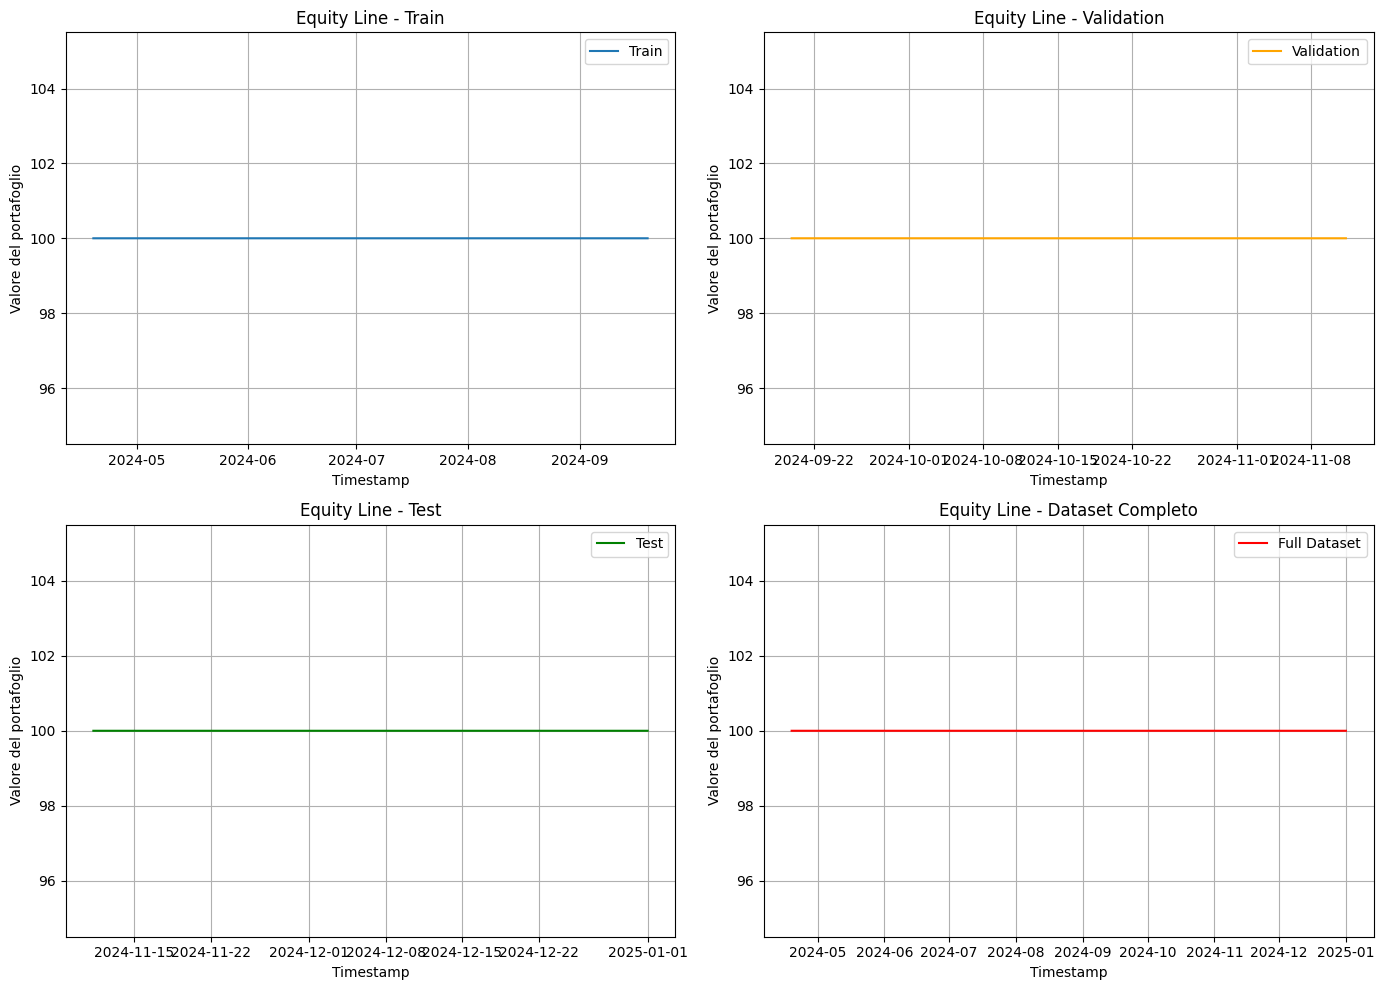

In [10]:
# Creazione dei grafici
plt.figure(figsize=(14, 10))

# Train
plt.subplot(2, 2, 1)
plt.plot(portfolio_df_train.index, portfolio_df_train['portfolio'], label='Train')
plt.title('Equity Line - Train')
plt.xlabel('Timestamp')
plt.ylabel('Valore del portafoglio')
plt.legend()
plt.grid()

# Validation
plt.subplot(2, 2, 2)
plt.plot(portfolio_df_val.index, portfolio_df_val['portfolio'], label='Validation', color='orange')
plt.title('Equity Line - Validation')
plt.xlabel('Timestamp')
plt.ylabel('Valore del portafoglio')
plt.legend()
plt.grid()

# Test
plt.subplot(2, 2, 3)
plt.plot(portfolio_df_test.index, portfolio_df_test['portfolio'], label='Test', color='green')
plt.title('Equity Line - Test')
plt.xlabel('Timestamp')
plt.ylabel('Valore del portafoglio')
plt.legend()
plt.grid()

# Dataset completo
plt.subplot(2, 2, 4)
plt.plot(portfolio_df_full.index, portfolio_df_full['portfolio'], label='Full Dataset', color='red')
plt.title('Equity Line - Dataset Completo')
plt.xlabel('Timestamp')
plt.ylabel('Valore del portafoglio')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()